<a href="https://colab.research.google.com/github/singhvis29/kaggle-genai-course/blob/main/Day_3_Building_an_agent_with_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 3 - Building an agent with LangGraph and the Gemini API

Welcome back to the Kaggle 5-day Generative AI course!

In this notebook, you will use [LangGraph](https://www.langchain.com/langgraph) to define a stateful graph-based application built on top of the Gemini API.

You will build a simulated cafe ordering system, called BaristaBot. It will provide a looping chat interface to customers where they can order cafe beverages using natural language, and you will build nodes to represent the cafe's live menu and the "back room" ordering system.

BaristaBot is used in other Gemini API demos, so if you are looking to explore something with a more minimal implementation, check out the [BaristaBot function calling example](https://github.com/google-gemini/cookbook/blob/main/examples/Agents_Function_Calling_Barista_Bot.ipynb) that implements a similar system using only the Gemini API Python SDK and function calling.

## **IMPORTANT!**

The app built in this notebook takes **user input** using a **text box** ([Python's `input`](https://docs.python.org/3/library/functions.html#input)). These are commented-out to ensure that you can use the `Run all` feature without interruption. Keep an eye out for the steps where you need to uncomment the `.invoke(...)` calls in order to interact with the app.

If you wish to save a version of this notebook with `Save and Run all`, you will need to **re-comment** the lines you commented-out to ensure that the notebook can run without human input.

## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**

## Get set up

Start by installing and importing the LangGraph SDK and LangChain support for the Gemini API.

In [4]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 19.1 MB/s eta 0:00:00


### Set up your API key

The `GOOGLE_API_KEY` environment variable can be set to automatically configure the underlying API. This works for both the official Gemini Python SDK and for LangChain/LangGraph.

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [12]:
import os
from google.colab import userdata
# from kaggle_secrets import UserSecretsClient

# GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
# os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

## Key concepts

LangGraph applications are built around a **graph** structure. As the developer, you define an application graph that models the state transitions for your application. Your app will define a **state** schema, and an instance of that schema is propagated through the graph.

Each **node** in the graph represents an action or step that can be taken. Nodes will make changes to the state in some way through code that you define. These changes can be the result of invoking an LLM, by calling an API, or executing any logic that the node defines.

Each **edge** in the graph represents a transition between states, defining the flow of the program. Edge transitions can be fixed, for example if you define a text-only chatbot where output is always displayed to a user, you may always transition from `chatbot -> user`. The transitions can also be conditional, allowing you to add branching (like an `if-else` statement) or looping (like `for` or `while` loops).

LangGraph is highly extensible and provides a number of features that are not part of this tutorial, such as memory, persistance and streaming. To better understand the key concepts and philophies behind LangGraph, check out their [Conceptual guides](https://langchain-ai.github.io/langgraph/concepts/) and [High-level overview](https://langchain-ai.github.io/langgraph/concepts/high_level/).

## Define core instructions

State is a fundamental concept for a LangGraph app. A state object is passed between every node and transition in the app. Here you define a state object, `OrderState`, that holds the conversation history, a structured order, and a flag indicating if the customer has finished placing their order. For simplicity, the "structure" in this order is just a list of strings, but this can be expanded to any Python data structure.

In Python, the LangGraph state object is a Python [dictionary](https://docs.python.org/3/library/stdtypes.html#dict). You can provide a schema for this dictionary by defining it as a [`TypedDict`](https://docs.python.org/3/library/typing.html#typing.TypedDict).

Here you also define the system instruction that the Gemini model will use. You can capture tone and style here, as well as the playbook under which the chatbot should operate.

In [13]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

## Define a single turn chatboot

To illustrate how LangGraph works, the following program defines a chatbot node that will execute a single turn in a chat conversation using the instructions supplied.

Each node in the graph operates on the state object. The state (a Python dictionary) is passed as a parameter into the node (a function) and the new state is returned. This can be restated as pseudo-code, where `state = node(state)`.

Note: For the `chatbot` node, the state is updated by *adding* the new conversation message. The `add_messages` annotation on `OrderState.messages` indicates that messages are *appended* when returned from a node. Typically state is updated by replacement, but this annotation causes `messages` to behave differently.

In [14]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

# Try using different models. The Gemini 2.0 flash model is highly
# capable, great with tools, and has a generous free tier. If you
# try the older 1.5 models, note that the `pro` models are better at
# complex multi-tool cases like this, but the `flash` models are
# faster and have more free quota.
# Check out the features and quota differences here:
#  - https://ai.google.dev/gemini-api/docs/models/gemini
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}


# Set up the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

It can be helpful to visualise the graph you just defined. The following code renders the graph.

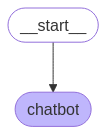

In [15]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

Now that the graph is defined, you can run it. It only has one node, and one transition into that node, so it will transition from `__start__` to `chatbot`, execute the `chatbot` node, and terminate.

To run the graph, you call `invoke` and pass an initial state object. In this case it begins with the user's initial message.

In [16]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to
# see it all. pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu items, answer questions, and put together your perfect order. What are you in the mood for today?


You could execute this in a Python loop, but for simplicity, manually invoke one more conversational turn. This second invocation takes the state from the first call and appends another user message to elicit another response from the chatbot.

In [17]:
user_msg = "Oh great, what kinds of latte can you make?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hi there! I'm BaristaBot, ready to take your coffee order. I can tell you about our menu items, answer questions, and put together your perfect order. What are you in the mood for today?
HumanMessage: Oh great, what kinds of latte can you make?
AIMessage: We have a few delicious latte options:

*   **Latte:** Our classic latte.
*   **Mocha Latte:** A chocolatey version of our latte.
*   **Caramel Latte:** A sweet and decadent latte.
*   **Vanilla Latte:** A latte infused with vanilla.

Would you like to know more about any of these?


## Add a human node

Instead of repeatedly running the "graph" in a Python loop, you can use LangGraph to loop between nodes.

The `human` node will display the last message from the LLM to the user, and then prompt them for their next input. Here this is done using standard Python `print` and `input` functions, but for a real cafe situation, you could render the chat to a display or audio, and accept input from a mic or on-screen keyboard.

The `chatbot` node function has also been updated to include the welcome message to start the conversation.

In [18]:
from langchain_core.messages.ai import AIMessage


def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

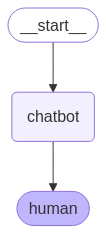

In [20]:
from IPython.display import Image, display

chat_graph = graph_builder.compile()

Image(chat_graph.get_graph().draw_mermaid_png())

Before you can run this, note that if you added an edge from `human` back to `chatbot`, the graph will cycle forever as there is no exit condition. One way to break the cycle is to add a check for a human input like `q` or `quit` and use that to break the loop.

In LangGraph, this is achieved with a conditional edge. This is similar to a regular graph transition, except a custom function is called to determine which edge to traverse.

Conditional edge functions take the state as input, and return a string representing the name of the node to which it will transition.

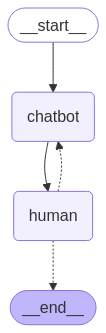

In [21]:
from typing import Literal


def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

Run this new graph to see how the interaction loop is now captured within the graph. Input `quit` to exit the program.

**You must uncomment the `.invoke(...)` line to run this step.**

In [22]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

pprint(state)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
User: Do you have a mocha?
Model: ```tool_code
add_to_order(item='Mocha')
```
User: What is the best coffee bean?
Model: That's a matter of taste, but our current favorite is the Ethiopian Yirgacheffe. It has a bright, floral flavor with a hint of citrus. We use it in our pour-over and it's also available for purchase by the bag. Would you like to add a bag to your order?
User: can i order a banana bread loaf?
Model: ```tool_code
add_to_order(item='Banana Bread')
```
User: what are other menu items?
Model: Besides the Mocha and Banana Bread you've already ordered, we have:

**Coffee:**

*   Espresso
*   Americano
*   Latte
*   Cappuccino
*   Iced Coffee
*   Pour-Over

**Pastries:**

*   Croissant
*   Chocolate Croissant
*   Blueberry Muffin

Would you like to add anything else?
User: No, q
Model: ```tool_code
confirm_order()
```
User: q
{'finished': True,
 'messages': [AIMessage(content='Welcome to the 

## Add a "live" menu

BaristaBot currently has no awareness of the available items at the cafe, so it will hallucinate a menu. One option would be to hard-code a menu into the system prompt. This would work well, but to simulate a system where the menu is more dynamic and could respond to fluctuating stock levels, you will put the menu into a custom tool.

There are two types of tools that this system will use. Stateless tools that can be run automatically, and stateful tools that modify the order. The "get current menu" tool is stateless, in that it does not make any changes to the live order, so it can be called automatically.

In a LangGraph app, you can annotate Python functions as tools by applying the `@tools` annotation.



In [23]:
from langchain_core.tools import tool


@tool
def get_menu() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text, but you could connect this to a live stock
    # database, or you could use Gemini's multi-modal capabilities and take live photos of
    # your cafe's chalk menu or the products on the counter and assmble them into an input.

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """

Now add the new tool to the graph. The `get_menu` tool is wrapped in a [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode) that handles calling the tool and passing the response as a message through the graph. The tools are also bound to the `llm` object so that the underlying model knows they exist. As you now have a different `llm` object to invoke, you need to update the `chatbot` node so that it is aware of the tools.


In [ ]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_menu]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(OrderState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())

Now run the new graph to see how the model uses the menu.

**You must uncomment the `.invoke(...)` line to run this step.**

In [ ]:
# Remember that you have not implemented ordering yet, so this will loop forever,
# unless you input `q`, `quit` or one of the other exit terms defined in the
# `human_node`.
# Uncomment this line to execute the graph:
# state = graph_with_menu.invoke({"messages": []}, config)

# Things to try:
# - I'd love an espresso drink, what have you got?
# - What teas do you have?
# - Can you do a long black? (this is on the menu as an "Americano" - see if it can
#   figure it out)
# - 'q' to exit.


# pprint(state)

## Handle orders

To build up an order during the chat conversation, you will need to update the state to track the order, and provide simple tools that update this state. These need to be explicit as the model should not directly have access to the apps internal state, or it risks being manipulated arbitrarily.

The ordering tools will be added as stubs in a separate node so that you can edit the state directly. Using the `@tool` annotation is still a handy way to define their schema, so the ordering tools below are implemented as empty Python functions.

In [ ]:
from collections.abc import Iterable
from random import randint

from langchain_core.messages.tool import ToolMessage

# These functions have no body; LangGraph does not allow @tools to update
# the conversation state, so you will implement a separate node to handle
# state updates. Using @tools is still very convenient for defining the tool
# schema, so empty functions have been defined that will be bound to the LLM
# but their implementation is deferred to the order_node.


@tool
def add_to_order(drink: str, modifiers: Iterable[str]) -> str:
    """Adds the specified drink to the customer's order, including any modifiers.

    Returns:
      The updated order in progress.
    """


@tool
def confirm_order() -> str:
    """Asks the customer if the order is correct.

    Returns:
      The user's free-text response.
    """


@tool
def get_order() -> str:
    """Returns the users order so far. One item per line."""


@tool
def clear_order():
    """Removes all items from the user's order."""


@tool
def place_order() -> int:
    """Sends the order to the barista for fulfillment.

    Returns:
      The estimated number of minutes until the order is ready.
    """


def order_node(state: OrderState) -> OrderState:
    """The ordering node. This is where the order state is manipulated."""
    tool_msg = state.get("messages", [])[-1]
    order = state.get("order", [])
    outbound_msgs = []
    order_placed = False

    for tool_call in tool_msg.tool_calls:

        if tool_call["name"] == "add_to_order":

            # Each order item is just a string. This is where it assembled as "drink (modifiers, ...)".
            modifiers = tool_call["args"]["modifiers"]
            modifier_str = ", ".join(modifiers) if modifiers else "no modifiers"

            order.append(f'{tool_call["args"]["drink"]} ({modifier_str})')
            response = "\n".join(order)

        elif tool_call["name"] == "confirm_order":

            # We could entrust the LLM to do order confirmation, but it is a good practice to
            # show the user the exact data that comprises their order so that what they confirm
            # precisely matches the order that goes to the kitchen - avoiding hallucination
            # or reality skew.

            # In a real scenario, this is where you would connect your POS screen to show the
            # order to the user.

            print("Your order:")
            if not order:
                print("  (no items)")

            for drink in order:
                print(f"  {drink}")

            response = input("Is this correct? ")

        elif tool_call["name"] == "get_order":

            response = "\n".join(order) if order else "(no order)"

        elif tool_call["name"] == "clear_order":

            order.clear()
            response = None

        elif tool_call["name"] == "place_order":

            order_text = "\n".join(order)
            print("Sending order to kitchen!")
            print(order_text)

            # TODO(you!): Implement cafe.
            order_placed = True
            response = randint(1, 5)  # ETA in minutes

        else:
            raise NotImplementedError(f'Unknown tool call: {tool_call["name"]}')

        # Record the tool results as tool messages.
        outbound_msgs.append(
            ToolMessage(
                content=response,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )

    return {"messages": outbound_msgs, "order": order, "finished": order_placed}


def maybe_route_to_tools(state: OrderState) -> str:
    """Route between chat and tool nodes if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    msg = msgs[-1]

    if state.get("finished", False):
        # When an order is placed, exit the app. The system instruction indicates
        # that the chatbot should say thanks and goodbye at this point, so we can exit
        # cleanly.
        return END

    elif hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        # Route to `tools` node for any automated tool calls first.
        if any(
            tool["name"] in tool_node.tools_by_name.keys() for tool in msg.tool_calls
        ):
            return "tools"
        else:
            return "ordering"

    else:
        return "human"

Now define the graph. The LLM needs to know about the tools too, so that it can invoke them. Here you set up 2 sets of tools corresponding to the nodes under which they operate: automated and ordering.

In [ ]:
# Auto-tools will be invoked automatically by the ToolNode
auto_tools = [get_menu]
tool_node = ToolNode(auto_tools)

# Order-tools will be handled by the order node.
order_tools = [add_to_order, confirm_order, get_order, clear_order, place_order]

# The LLM needs to know about all of the tools, so specify everything here.
llm_with_tools = llm.bind_tools(auto_tools + order_tools)


graph_builder = StateGraph(OrderState)

# Nodes
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("ordering", order_node)

# Chatbot -> {ordering, tools, human, END}
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human -> {chatbot, END}
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools (both kinds) always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("ordering", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_order_tools = graph_builder.compile()

Image(graph_with_order_tools.get_graph().draw_mermaid_png())

Now run the complete ordering system graph.

**You must uncomment the `.invoke(...)` line to run this step.**

In [ ]:
# Uncomment this line to execute the graph:
# state = graph_with_order_tools.invoke({"messages": []}, config)

# Things to try:
# - Order a drink!
# - Make a change to your order.
# - "Which teas are from England?"
# - Note that the graph should naturally exit after placing an order.

# pprint(state)

The order state has been captured both in the `place_order` function and in the final conversational state returned from executing the graph. This iillustrates how you can integrate your own systems to a graph app, as well as collect the final results of executing such an app.

In [ ]:
# Uncomment this once you have run the graph from the previous cell.
# pprint(state["order"])

## Further exercises

Congratulations on building an agentic, human-in-the-loop, natural-language powered cafe ordering system using LangGraph and the Gemini API!

This example app could be taken in many different directions. You should try and build out your own ideas, but for some inspiration, consider:

* Adding more structure the order (`OrderState.order`) - e.g. separate fields for item, modifiers and even quantity.
* Currently the model can only clear and re-add items, so add a function to `remove_item`s from the order.
* Try building a UI that displays the in-progress order and hosts the chat. Frameworks like [Gradio](https://www.gradio.app/) or [Mesop](https://google.github.io/mesop/) are great for this.

This system works well for a single person ordering, but agentic systems can interact with many sources. For a big stretch exercise, try and extend this app to run at a specific schedule, and contact your friends or colleagues over [Chat](https://developers.google.com/workspace/chat/api/reference/rest) to collect their daily coffee orders.

*- [Mark McD](https://linktr.ee/markmcd)*